# Train a PdM Agent using Behavior Cloning

- 25-Jul-2024: V.1.0 - Re-create
- 28-Jul-2024: V.1.1 - Add logging
- 28-Jul-2024: V.2.0 - Add other algos to compare with BC
  1. SQIL is straightforward and similar to BC implementation 
  2. Adversarial IRL and GAIL - appear to require Discriminator and therefore a "Reward Net" - more complex so do next

In [1]:
DATA_FILE = 'PHM_C01.csv'
WEAR_THRESHOLD = wear_thresholds['W1']

# training_expts = ['W1', 'W2','W3','W4']
# wear_thresholds = {'W1':0.229, 'W2':0.12, 'W3':0.12, 'W4':0.2} # Based on 'observation'

SAMPLING_RATE = 1
ADD_NOISE = 0

column_names = ['timestamp', 'vibration_x', 'vibration_y', 'force_z', 'tool_wear']

In [2]:
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

from utilities import downsample

In [3]:
import gym
from gym import spaces
import pandas as pd
import numpy as np

LAMBDA = 0.01

NO_ACTION = 0
REPLACE = 1

MAX_OP_CYCLES = 0.0 # 

time_since_last_replacement = 0

a_time = []
a_cost = []
a_action_recommended = []
a_actions = []
a_action_text = []
a_rul = []
a_rewards = []
a_replacements = []
a_time_since_last_replacement = []

class MillingTool(gym.Env):
    """Custom Milling Tool Wear Environment that follows the Open AI gym interface.
    Single-variate env. Terminate on (1) tool breakdown (2) data-end (3) milling operations end.
    """

    metadata = {"render.modes": ["human"]}

    def __init__(self, df = None, wear_threshold=1.0, max_operations=100, add_noise=0.0, breakdown_chance=0.0, R1=1.0, R2=-1.0, R3=-100.0):
        print(f'** -- Milling Tool Wear Single-variate env. Wear_threshold: {wear_threshold:.4f} R1: {R1}, R2: {R2}, R3: {R3}. Noise: {add_noise}. Break-down chance: {breakdown_chance} -- **')

        # Machine data frame properties
        if df is not None:
            self.df = df
            self.records = len(self.df.index)
        else:
            self.records = -1 # Indicates - no dataframe
        # self.df_index = 0

        # Initialization
        self.current_time_step = 0  # Initial state, this will be INCREMENTED every step
        # self.max_op_cycles = max_op_cycles    # Store max life (max RUL) of tool
        self.tool_failure_thresholds = tool_failure_thresholds # Product quality unacceptable - must replace
        self.tool_failure_times = tool_failure_times
        # self.rul = self.df.loc[self.current_time_step, 'RUL']   # Initial RUL, this will be DECREMENTED every step. Also the DONE condition
        # self.rul = self.starting_rul 
        self.time_at_replacement = 0
        self.time_since_last_replacement = 0
        self.maintenance_cost = 0.0        
        self.replacement_events = 0
        self.reward = 0.0
        self.current_action = NO_ACTION
        
        # Observation vector: Time, vibration, force
        # column_names = ['timestamp', 'vibration_x', 'vibration_y', 'force_z', 'tool_wear', 'RUL', 'ACTION_CODE']
        # Observation space upper limits
        high = np.array(
            [
                self.records, # Max time
                1.0,          # Max. vibration_x
                1.0,          # Max. vibration_y
                1.0,          # Max. force_z
            ],
            dtype=np.float32,
        )

        # observation space lower limits
        low = np.array(
            [
                0,            # Min. time
                -1.0,         # Min. vibration_x
                -1.0,         # Min. vibration_y
                -1.0,         # Min. force_z
            ],
            dtype=np.float32,
        )
        
        self.action_space = spaces.Discrete(2) # Normal and replace
        self.observation_space = spaces.Box(low, high, dtype=np.float32)
        self.state = None
        print(f'Milling tool environment initiated. Number of experiments: {len(self.tool_failure_thresholds)}. Number of records: {self.records}')
            
    def _next_observation(self):
        frame = np.array([
            self.df.loc[self.current_time_step, 'time'],
            self.df.loc[self.current_time_step, 'vibration_x'],
            self.df.loc[self.current_time_step, 'vibration_y'],
            self.df.loc[self.current_time_step, 'force_z'],
        ])
        
        # Append additional data and scale each value to between 0-1
        obs = frame.flatten()
        return obs

    def _take_action(self, action):

        if action == NO_ACTION: # Normal state
            # 1% reduction in life
            self.maintenance_cost += 0.1            
            self.current_time_step += 1
            action_text = 'None'
                        
        elif action == REPLACE:
            # Replace the tool -- Starting RUL will now be random but around the RUL we have
            self.maintenance_cost += 10.0            
            self.replacement_events += 1            
            # self.time_since_last_replacement = self.current_time_step - self.time_at_replacement
            # self.time_at_replacement = self.current_time_step
            self.time_since_last_replacement = self.current_time_step
            # self.current_time_step = 0
            a_time_since_last_replacement.append(self.time_since_last_replacement)
            print(f' ============ Time since last replacement: {self.time_since_last_replacement} ==============')            
            action_text = '* REPLACE *' 
                    
        self.reward = (self.current_time_step + 1) / (self.maintenance_cost+LAMBDA)
        
        a_actions.append(action)
        a_action_text.append(action_text)

        print('{0:<20} | RUL: {1:>8.2f} | Cost: {2:>8.2f} | Reward: {3:>12.3f}'.format(action_text, self.rul, self.maintenance_cost, self.reward))
                 
        self.state = (self.rul, self.maintenance_cost, action)


    ## Step function
    #  This is a time step:
    #   1. Take action, and assign reward (calls _take_action())
    #   2. Increment the time-step i.e. self.current_time_step ++
    #   3. Decrease life i.e. self.rul = next lower RUL
    def step(self, action):

        ## Find the RUL
        # self.rul = self.df.loc[self.current_time_step, 'RUL']
        ## For this current time - take action
        self._take_action(action)
        reward = self.reward

        ## Check for termination
        #  Records over
        if self.current_time_step >= (self.records-1):
            self.current_time_step = 0
            done = True
        elif self.rul <= 1: # Less-than-equal 0 (or near zero)
            done = True
        else:
            done = False

        ## For this current time - record all values
        a_time.append(self.current_time_step)
        a_rewards.append(self.reward)
        a_rul.append(self.rul)
        a_cost.append(self.maintenance_cost)
        # a_events.append(self.maintenance_events)
        a_replacements.append(self.replacement_events)
        # From database extract recommended action
        recommended_action = self.df.loc[self.current_time_step, 'ACTION_CODE']

        a_action_recommended.append(recommended_action)

        ## Now, increment current time step
        self.current_time_step += 1
        self.time_since_last_replacement += 1
        obs = self._next_observation()
        
        return obs, reward, done, {}

    def reset(self):
        # Reset environment variables and stats.
        self.current_time_step = 0
        self.reward = 0.0
        self.rul = self.df.loc[self.current_time_step, 'RUL']
        print('\n --- RESET. Starting RUL = ', self.rul)

        # Reset the state of the environment to an initial state
        self.time_since_last_replacement = 0
        self.maintenance_cost = 0.0
        # self.maintenance_events = 0
        self.replacement_events = 0
        self.reward = 0.0
        self.current_action = NO_ACTION

        ## For this current time - record all values
        a_time.append(self.current_time_step)
        

        a_replacements.append(self.replacement_events)
        a_rewards.append(self.reward)
        a_rul.append(self.rul)
        a_cost.append(self.maintenance_cost)
        print(120*'=')
        print(f'==================== RESET: Maintenance cost reset: {self.maintenance_cost} Time since last replacement: {self.time_since_last_replacement}====================')
        print(120*'=')
        # a_events.append(self.maintenance_events)

        # Reset done before returning
        done = False

        return np.array(self.state, dtype=np.float32)

    def render(self, mode='human', close=False):
        # Render the environment to the screen
        RUL = self.rul
        
        # print('>> {0:<20} | RUL: {1:>8.2f} | Cost: {2:>8.2f} | Reward: {3:>12.3f}'.
            #   format(self.current_action, self.rul, self.maintenance_cost, self.reward))

In [4]:
def tool_wear_data(data_file, wear_threshold, normalize=False, add_noise=False, sampling_rate=1):
    ## Read data
    df_raw = pd.read_csv(data_file)

    df = downsample(df_raw, sampling_rate)

    # Reset index as the downsampling disturbs the index and then PPO.learn() fails. Gives a "Key error"
    df = df.reset_index(drop=True)
    n_points = len(df.index)

    # 1. Add white noise for robustness
    if add_noise:
        df['tool_wear'] = df['tool_wear'] + np.random.normal(0, 1, n_points)/add_noise

    # Normalize
    if normalize:
        WEAR_MIN = df['tool_wear'].min() 
        WEAR_MAX = df['tool_wear'].max()
        # WEAR_THRESHOLD_NORMALIZED = THRESHOLD_FACTOR*(wear_threshold-WEAR_MIN)/(WEAR_MAX-WEAR_MIN)
        WEAR_THRESHOLD_NORMALIZED = 0
        df_normalized = (df-df.min())/(df.max()-df.min())

        # df_normalized['ACTION_CODE'] = np.where(df_normalized['tool_wear'] < WEAR_THRESHOLD_NORMALIZED, 0.0, 1.0)
        # print(f'Tool wear data imported ({n_points} records). WEAR_THRESHOLD_NORMALIZED: {WEAR_THRESHOLD_NORMALIZED:4.3f}')

        df_train = df_normalized.copy(deep=True)

        tool_wear = df_normalized['tool_wear']
        action_code_normalized = df_normalized['ACTION_CODE']
        action_code = df['ACTION_CODE']
        df_train['ACTION_CODE'] = df['ACTION_CODE']
    else:
        df_train = df.copy(deep=True)
        tool_wear = df['tool_wear']
        action_code = df['ACTION_CODE']

    plt.figure(figsize=(10, 2.5))
    plt.plot(tool_wear, linewidth=1)

    
    if normalize:
        plt.plot(action_code_normalized, linewidth=1)
        wear_threshold_return = WEAR_THRESHOLD_NORMALIZED
        # plt.axhline(y = WEAR_THRESHOLD_NORMALIZED, color = 'r', linestyle = '--', alpha=0.3) 
    else:
        plt.plot(action_code/4, linewidth=1)
        wear_threshold_return = wear_threshold
        # plt.axhline(y = wear_threshold, color = 'r', linestyle = '--', alpha=0.3) 

    plt.title(f'Tool wear (IEEE NUAA W1, W2, W3 and W4)')
    plt.grid(color='lightgray', linestyle='-', linewidth=0.5)
    plt.show()

    return tool_wear, action_code, wear_threshold_return, df_train

- Down-sampling. Input data records: 102. Sampling rate: 1. Expected rows 102.    Down-sampled to 102 rows.


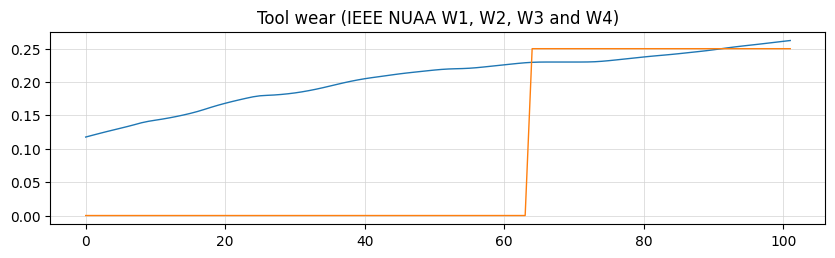

Tool failure time-point: 1833.335


In [7]:
tool_wear, action_code, WEAR_THRESHOLD_NORMALIZED, df_train = tool_wear_data(
    data_file=NUAA_DATA_FILE, wear_threshold = WEAR_THRESHOLD,
    normalize=False, add_noise=ADD_NOISE, sampling_rate = SAMPLING_RATE)


failure_point = df_train.loc[df_train['ACTION_CODE'] == 1].iloc[0]
TOOL_FAILURE_TIME = failure_point['timestamp']
print(f'Tool failure time-point: {TOOL_FAILURE_TIME:3.3f}')

In [5]:
TOOL_FAILURE_TIME=0

In [6]:
import warnings
from tqdm import tqdm # Progress bar
from datetime import datetime
warnings.filterwarnings('ignore')

# General libraries
import pandas as pd
import numpy as np

# RL libraries
import gymnasium as gym
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3 import PPO, A2C
from stable_baselines3.ppo import MlpPolicy
from torch.utils.tensorboard import SummaryWriter

# CH-AI Imitation libraries
from imitation.util.util import make_vec_env
from imitation.data import rollout
from imitation.data.wrappers import RolloutInfoWrapper

# Custom libraries
# from milling_tool_env import MillingTool

In [9]:
now = datetime.now()
dt_string = now.strftime("%d-%b-%Y  %H:%M:%S")

PATH = 'D:/ResearchLab/IRL/BC_for_PdM_July_2024/'
LOG_PATH = f'{PATH}/tensorboard/{now.strftime("%d-%b-%Y_%H_%M")}/'
writer = SummaryWriter(LOG_PATH)
print(f'Tensorboard logging to {LOG_PATH}')

Tensorboard logging to D:/ResearchLab/IRL/BC_for_PdM_July_2024//tensorboard/30-Jul-2024_21_43/


In [7]:
SAMPLE_DEMONSTRATIONS = 10
EPISODES = 200 # Train the Expert for N episodes
BATCH_SIZE = 16 
LEARNING_RATE = int(1e-3)
EVALUATION_ROUNDS = 10

# Milling tool env.
DATA_FILE = 'PHM_C01.csv'
R1, R2, R3 = 2.0, -1.0, -20.0
WEAR_THRESHOLD = 0.12 # mm
THRESHOLD_FACTOR = 1.0
ADD_NOISE = 0 # 0=No noise, Low=1e3, High=1e2 
BREAKDOWN_CHANCE = 0 # Recommended: 0.05 = 5%
MILLING_OPERATIONS_MAX = 300

## 1. Creating the PdM Milling tool environment

In [8]:
## Read tool-wear data
df = pd.read_csv(DATA_FILE)
WEAR_MIN = df['tool_wear'].min() 
WEAR_MAX = df['tool_wear'].max()
WEAR_THRESHOLD_NORMALIZED = THRESHOLD_FACTOR*(WEAR_THRESHOLD-WEAR_MIN)/(WEAR_MAX-WEAR_MIN)
df_normalized = (df-df.min())/(df.max()-df.min())
df_normalized['ACTION_CODE'] = np.where(df_normalized['tool_wear'] < WEAR_THRESHOLD_NORMALIZED, 0.0, 1.0)
print(f'Tool wear data imported ({len(df.index)} records). WEAR_THRESHOLD_NORMALIZED: {WEAR_THRESHOLD_NORMALIZED:4.3f}')
df_train = df_normalized

# gym.register(
#     id = 'custom/MillingTool-v0',
#     entry_point = MillingTool,
#     max_episode_steps = MILLING_OPERATIONS_MAX,
# )

# # Vectorized environment: Use the `make_vec_env` helper function - make sure to pass `post_wrappers=[lambda env, _: RolloutInfoWrapper(env)]`
# env_kwargs = {'df':df_train, 'wear_threshold':WEAR_THRESHOLD_NORMALIZED, 'max_operations':MILLING_OPERATIONS_MAX,
#                'add_noise':ADD_NOISE, 'breakdown_chance':BREAKDOWN_CHANCE, 'R1':R1, 'R2':R2, 'R3':R3}

# mt_venv = make_vec_env(
#     'custom/MillingTool-v0',
#     env_make_kwargs=env_kwargs,
#     rng=np.random.default_rng(),
#     n_envs=1,
#     post_wrappers=[lambda mt_venv, _: RolloutInfoWrapper(mt_venv)],
# )

Tool wear data imported (1000 records). WEAR_THRESHOLD_NORMALIZED: 0.574


In [9]:
gym.register(
    id = 'custom/MillingToolNUAA-v0',
    entry_point = MillingToolEnv_NUAA,
    max_episode_steps = MILLING_OPERATIONS_MAX,
)

# Vectorized environment: Use the `make_vec_env` helper function - make sure to pass `post_wrappers=[lambda env, _: RolloutInfoWrapper(env)]`
env_kwargs = {'df':df_train, 'max_op_cycles':MILLING_OPERATIONS_MAX, 'tool_failure_thresholds':WEAR_THRESHOLD_NORMALIZED, 
              'tool_failure_times':TOOL_FAILURE_TIME}

mt_venv_nuaa = make_vec_env(
    'custom/MillingToolNUAA-v0',
    env_make_kwargs=env_kwargs,
    rng=np.random.default_rng(),
    n_envs=1,
    post_wrappers=[lambda mt_venv_nuaa, _: RolloutInfoWrapper(mt_venv_nuaa)],
)

None


** -- NUAA Milling Tool Wear environment. Error: NO TOOL WEAR DATA SUPPLIED !! -- **


Milling tool environment initiated. Number of experiments: 1. Number of records: -1


AssertionError: action space does not inherit from `gymnasium.spaces.Space`, actual type: <class 'gym.spaces.discrete.Discrete'>

### Create the Milling environent 
- Default method of creating is `env_mt = gym.make('custom/MillingTool-v0')`
- This does **not** work with `imitation` IRL
- Must create a vectorized env. using `make_vec_env` utility

In [96]:
# Vectorized environment: Use the `make_vec_env` helper function - make sure to pass `post_wrappers=[lambda env, _: RolloutInfoWrapper(env)]`
env_kwargs = {'df':df_train, 'max_op_cycles':MILLING_OPERATIONS_MAX, 'tool_failure_thresholds':WEAR_THRESHOLD_NORMALIZED, 
              'tool_failure_times':TOOL_FAILURE_TIME}

mt_venv = make_vec_env(
    'custom/MillingToolNUAA-v0',
    env_make_kwargs=env_kwargs,
    rng=np.random.default_rng(),
    n_envs=1,
    post_wrappers=[lambda mt_venv, _: RolloutInfoWrapper(mt_venv)],
)

# Load the wear data dataframe
# mt_venv.load_df(df=df_train)



** -- NUAA Milling Tool Wear environment. Error: NO TOOL WEAR DATA SUPPLIED !! -- **




AttributeError: 'MillingToolEnv_NUAA' object has no attribute 'df'

## 2. The "Human" Expert (here we create one)

In [6]:
# expert_a2c = A2C('MlpPolicy', env_mt)
# expert_a2c.learn(total_timesteps=EPISODES)

In [7]:
expert_ppo = PPO(
    policy = MlpPolicy,
    env = mt_venv,
    # seed = 0,
    batch_size = 64,
    ent_coef = 0.0,
    learning_rate = LEARNING_RATE,
    n_epochs = 10,
    n_steps = 64,
    tensorboard_log=LOG_PATH,
)

expert_ppo.learn(EPISODES) 

Check PPO Expert reward

In [8]:
reward, _ = evaluate_policy(expert_ppo, mt_venv, EVALUATION_ROUNDS)
print(f'PPO Expert reward: {reward}')

# reward, _ = evaluate_policy(expert_a2c, env_mt, 10)
# print(reward)

PPO Expert reward: 8999.899999999998


## 3. Demonstrations from the the Expert

- Use the expert to sample some trajectories.
- Flatten them to obtain individual transitions for behavior cloning

#### Implementation details: 
- Use `imitation` utilities - Collect 50 episode rollouts, then flatten them to just the transitions that we need for training.
- `rollout` function requires a vectorized environment and needs the `RolloutInfoWrapper` around each of the environments
- This is why we passed the `post_wrappers` argument to `make_vec_env` above.

In [9]:
rng = np.random.default_rng()

rollouts = rollout.rollout(
    expert_ppo,
    mt_venv,
    rollout.make_sample_until(min_timesteps=None, min_episodes=SAMPLE_DEMONSTRATIONS),
    rng = rng,
)

transitions = rollout.flatten_trajectories(rollouts)

Let's have a quick look at what we just generated using those library functions:

```print(f"""The `rollout` function generated a list of {len(rollouts)} {type(rollouts[0])}.
After flattening, this list is turned into a {type(transitions)} object containing {len(transitions)} transitions.
The transitions object contains arrays for: {', '.join(transitions.__dict__.keys())}."
""")```

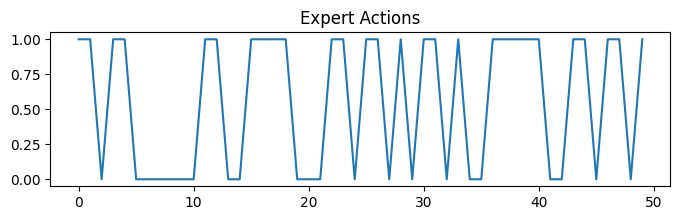

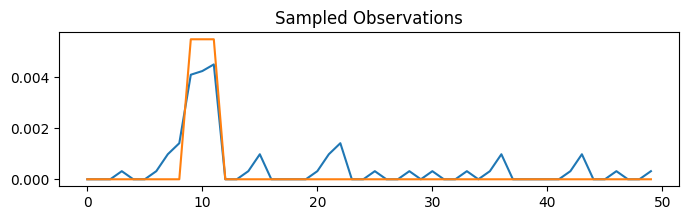

In [10]:
import matplotlib.pyplot as plt
obsvs = []
acts = []

for n in range(len(rollouts)):
    acts.append(transitions.acts[n])
    obsvs.append(transitions.obs[n])

plt.figure(figsize=(8, 2))
plt.title('Expert Actions')
plt.plot(acts)

plt.figure(figsize=(8, 2))
plt.title('Sampled Observations')
plt.plot(obsvs)

After we collected our transitions, it's time to set up our behavior cloning algorithm.

In [11]:
from imitation.algorithms import bc
from imitation.util import logger as imit_logger

# Set new logger
tmp_path_irl = f'{PATH}/tensorboard/irl_log/BC/'
new_logger_irl = imit_logger.configure(tmp_path_irl, ["stdout", "csv", "tensorboard"])

bc_trainer = bc.BC(
    observation_space=mt_venv.observation_space,
    action_space=mt_venv.action_space,
    demonstrations=transitions,
    batch_size=BATCH_SIZE,
    rng=rng,
    device='cpu',
    custom_logger = new_logger_irl
)

As you can see the untrained policy only gets poor rewards:

In [12]:
reward_before_training, _ = evaluate_policy(bc_trainer.policy, mt_venv, EVALUATION_ROUNDS)
print(f"Reward before training: {reward_before_training: 4.3f}")

Reward before training: -405.000


## 4. Behavioural Cloning (BC) based learning from expert demonstrations

In [13]:
bc_trainer.train(n_epochs=1)

0batch [00:00, ?batch/s]

---------------------------------
| batch_size        | 16        |
| bc/               |           |
|    batch          | 0         |
|    ent_loss       | -0.000693 |
|    entropy        | 0.693     |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 68.5      |
|    loss           | 0.692     |
|    neglogp        | 0.693     |
|    prob_true_act  | 0.5       |
|    samples_so_far | 16        |
---------------------------------


477batch [00:01, 379.37batch/s]

---------------------------------
| batch_size        | 16        |
| bc/               |           |
|    batch          | 500       |
|    ent_loss       | -0.000693 |
|    entropy        | 0.693     |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 67.9      |
|    loss           | 0.693     |
|    neglogp        | 0.694     |
|    prob_true_act  | 0.5       |
|    samples_so_far | 8016      |
---------------------------------


907batch [00:02, 378.86batch/s]
937batch [00:02, 372.61batch/s]


In [14]:
now = datetime.now()
dt_string = now.strftime("%d-%b-%Y  %H:%M:%S")
reward_after_training, _ = evaluate_policy(bc_trainer.policy, mt_venv, EVALUATION_ROUNDS)

print('-'*120)
print(' **** IRL with Imitation Libraries and Milling environment ****')
print('-'*120)

print(dt_string)
print(f'Episodes: {EPISODES}')
print(f'Rewards Before: {reward_before_training:5.3f} | After: {reward_after_training:5.3f}')
# print(f'Training time: {elapsed_time:5.3f} seconds')

------------------------------------------------------------------------------------------------------------------------
 **** IRL with Imitation Libraries and Milling environment ****
------------------------------------------------------------------------------------------------------------------------
28-Jul-2024  20:38:28
Episodes: 200
Rewards Before: -405.000 | After: 8999.900


In [16]:
from imitation.algorithms import sqil
from imitation.util import logger as imit_logger

# Set new logger
tmp_path_irl = f'{PATH}/tensorboard/irl_log/SQIL/'
new_logger_irl = imit_logger.configure(tmp_path_irl, ["stdout", "csv", "tensorboard"])

sqil_trainer = sqil.SQIL(   
    venv = mt_venv,
    demonstrations = transitions,
    policy='MlpPolicy',
    # device='cpu',
    custom_logger = new_logger_irl
)

In [18]:
from stable_baselines3.common.evaluation import evaluate_policy

reward_before_training, _ = evaluate_policy(sqil_trainer.policy, mt_venv, 10)
print(f"Reward before training: {reward_before_training}")

Reward before training: -903.0


In [22]:
sqil_trainer.train(
    total_timesteps = 10_000, # Note: set to 1_000_000 to obtain good results
)  
reward_after_training, _ = evaluate_policy(sqil_trainer.policy, mt_venv, 10)
print(f"Reward after training: {reward_after_training:5.3f")

Reward after training: 466.71600000000007


In [ ]:
# sqil_trainer.train(
#     total_timesteps=1_000_000, # Note: set to 1_000_000 to obtain good results
# )  
# reward_after_training, _ = evaluate_policy(sqil_trainer.policy, mt_venv, 10)
# print(f"Reward after training: {reward_after_training}")